## Simulating future stock prices using MC
###### https://www.interviewqs.com/blog/intro-monte-carlo

In [ ]:
# Import required libraries

start = dt.datetime.today()-dt.timedelta(6000)
end = dt.datetime.today()
cl_price = pd.DataFrame()
ohlcv_data = {}
ticker = 'AAPL'

data = yf.download(ticker, start, end)
cl_price[ticker] = data['Adj Close']
ohlcv_data[ticker] = data

In [ ]:
#Next, we calculate the number of days that have elapsed in our chosen time window
time_elapsed = (data.index[-1] - data.index[0]).days
time_elapsed 

In [ ]:
#Current price / first record (e.g. price at beginning of 2009)
#provides us with the total growth %
total_growth = (data['Adj Close'][-1] / data['Adj Close'][1])

#Next, we want to annualize this percentage
#First, we convert our time elapsed to the # of years elapsed
number_of_years = time_elapsed / 365.0
#Second, we can raise the total growth to the inverse of the # of years
#(e.g. ~1/10 at time of writing) to annualize our growth rate
cagr = total_growth ** (1/number_of_years) - 1

#Now that we have the mean annual growth rate above,
#we'll also need to calculate the standard deviation of the
#daily price changes
std_dev = data['Adj Close'].pct_change().std()


#Next, because there are roughy ~252 trading days in a year,
#we'll need to scale this by an annualization factor
#reference: https://www.fool.com/knowledge-center/how-to-calculate-annualized-volatility.aspx
number_of_trading_days = 252
std_dev = std_dev * math.sqrt(number_of_trading_days)

#From here, we have our two inputs needed to generate random
#values in our simulation
print ("cagr (mean returns) : ", str(round(cagr,4)))
print ("std_dev (standard deviation of return : )", str(round(std_dev,4)))

In [ ]:
#Generate random values for 1 year's worth of trading (252 days),
#using numpy and assuming a normal distribution
daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev/math.sqrt(number_of_trading_days),number_of_trading_days)+1

#Now that we have created a random series of future
#daily return %s, we can simply apply these forward-looking
#to our last stock price in the window, effectively carrying forward
#a price prediction for the next year

#This distribution is known as a 'random walk'

price_series = [data['Adj Close'][-1]]

for j in daily_return_percentages:
    price_series.append(price_series[-1] * j)

#Great, now we can plot of single 'random walk' of stock prices
plt.plot(price_series)
plt.show()

In [ ]:
#Now that we've created a single random walk above,
#we can simulate this process over a large sample size to
#get a better sense of the true expected distribution
number_of_trials = 3000

#set up an additional array to collect all possible
#closing prices in last day of window.
#We can toss this into a histogram
#to get a clearer sense of possible outcomes
closing_prices = []

for i in range(number_of_trials):
    #calculate randomized return percentages following our normal distribution
    #and using the mean / std dev we calculated above
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev/math.sqrt(number_of_trading_days),number_of_trading_days)+1
    price_series = [data['Adj Close'][-1]]

    for j in daily_return_percentages:
        #extrapolate price out for next year
        price_series.append(price_series[-1] * j)

    #append closing prices in last day of window for histogram
    closing_prices.append(price_series[-1])

    #plot all random walks
    plt.plot(price_series)

plt.show()

#plot histogram
plt.hist(closing_prices,bins=40)

plt.show()

# Heston Model

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy import special
import warnings
import yfinance as yf
import pandas as pd
from datetime import datetime
import warnings
from time import time
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol


In [162]:
#data = yf.download('^OEX', '1991-01-01', '1997-06-01')

data = yf.download('AAPL', '2010-01-01', datetime.today())
df = pd.DataFrame(data['Close'])
df.reset_index(inplace=True)
df.rename(columns={'AAPL':'Close'},inplace=True)
df['Change in asset returns'] = df['Close']/df['Close'].shift(1)


[*********************100%***********************]  1 of 1 completed


### Method of Moments

In [163]:

mu_1 = (1/(len(df)-1))*df['Change in asset returns'].sum()
mu_2 = (1/(len(df)-1))*(df['Change in asset returns']**2).sum()
mu_3 = (1/(len(df)-1))*(df['Change in asset returns']**4).sum()
mu_5 = (1/(len(df)-1))*(df['Change in asset returns']**5).sum()

mu_1, mu_2, mu_3, mu_5

def equations(vars):
    r, theta, k, sigma = vars
    return [
        1+r-mu_1,
        (r+1)**2 + theta - mu_2,
        (1 / (k * k - 2)) * (
        np.power(k, 2) * np.power(r, 4) + 4 * np.power(k, 2) * np.power(r, 3)
        + 6 * np.power(k, 2) * np.power(r, 2) * theta - 2 * k * np.power(r, 4)
        + 6 * np.power(k, 2) * np.power(r, 2) + 12 * np.power(k, 2) * r * theta
        + 3 * np.power(k, 2) * np.power(theta, 2) - 8 * k * np.power(r, 3)
        - 12 * k * np.power(r, 2) * theta + 4 * np.power(k, 2) * r
        + 6 * np.power(k, 2) * theta - 12 * k * np.power(r, 2) - 24 * k * r * theta
        - 6 * k * np.power(theta, 2) - 3 * np.power(sigma, 2) * theta
        + np.power(k, 2) - 8 * k * r - 12 * k * theta - 2 * k
        ) - mu_3,
        (1 / (k * k - 2)) * (
        np.power(k, 2) * np.power(r, 5) + 5 * np.power(k, 2) * np.power(r, 4)
        + 10 * np.power(k, 2) * np.power(r, 3) * theta - 2 * k * np.power(r, 5)
        + 10 * np.power(k, 2) * np.power(r, 3) + 30 * np.power(k, 2) * np.power(r, 2) * theta
        + 15 * np.power(k, 2) * r * np.power(theta, 2) - 10 * k * np.power(r, 4)
        - 20 * k * np.power(r, 3) * theta + 10 * np.power(k, 2) * np.power(r, 2)
        + 30 * np.power(k, 2) * r * theta + 15 * np.power(k, 2) * np.power(theta, 2)
        - 20 * k * np.power(r, 3) - 60 * k * np.power(r, 2) * theta
        - 30 * k * r * np.power(theta, 2) - 15 * r * np.power(sigma, 2) * theta
        + 5 * np.power(k, 2) * r + 10 * np.power(k, 2) * theta - 20 * k * np.power(r, 2)
        - 60 * k * r * theta - 30 * k * np.power(theta, 2) - 15 * np.power(sigma, 2) * theta
        + np.power(k, 2) - 10 * k * r - 20 * k * theta - 2 * k
        ) - mu_5
    ]


initial_guess = [0.5, 0.5, 0.5,0.5]

# Solve the equations
solution = fsolve(equations, initial_guess, maxfev=100000)

print("Solution:")
print("r =", solution[0])
print("theta =", solution[1])
print("k =", solution[2])
print("sigma =", solution[3])




Solution:
r = 0.001099182903346273
theta = 0.00030811552444944646
k = 0.9999997077836494
sigma = 0.012136685335335578


### Maximum Likelihood Estimation

In [5]:
#df['variance_up_to_row'] = df['Change in asset returns'].expanding().var(ddof=1)

In [ ]:
def calculate_rolling_volatility(prices, window=21, annualize=True, trading_days=252):
    """
    Calculate rolling volatility from a series of stock prices.
    
    Parameters:
    -----------
    prices : array-like or pandas Series
        Time series of stock prices
    window : int, default 21
        Rolling window size (typically 21 for monthly)
    method : str, default 'returns'
        Method to calculate volatility:
        - 'returns': var of returns
    annualize : bool, default True
        Whether to annualize the volatility
    trading_days : int, default 252
        Number of trading days in a year, used for annualization
        
    Returns:
    --------
    pandas.Series
        Rolling volatility series
    """
    # Convert to pandas Series if not already
    prices = pd.Series(prices)
    
    # Calculate simple returns
    returns = prices.pct_change()
    # Calculate rolling standard deviation
    rolling_std = returns.rolling(window=window).var()

    
    # Annualize if requested
    if annualize:
        rolling_vol = rolling_std * np.sqrt(trading_days)
    else:
        rolling_vol = rolling_std
        
    return rolling_vol

df['variance_up_to_row'] = calculate_rolling_volatility(df['Change in asset returns'], window=21)
df['variance_up_to_row'].plot()


In [102]:
def log_likelihood(params, Q, V):
    """
    Calculate the log-likelihood function for given parameters and data.
    
    Parameters:
    -----------
    params : array-like
        Array containing [r, k, theta, sigma, rho]
        
    Q, V : array-like
        Data arrays
    """
    r, k, theta, sigma, rho = params
    
    # Parameter validation
    if sigma <= 0 or abs(rho) >= 1 or k<=0:
        return -np.inf
    
    # Convert inputs to numpy arrays
    Q = np.array(Q)
    V = np.array(V)
    n = len(V) - 1
    
    # Initialize sum
    ll = 0
    
    # Calculate the sum over all terms
    for t in range(n):
        term1 = -np.log(2 * np.pi) - np.log(sigma) - np.log(V[t])
        term2 = -0.5 * np.log(1 - rho**2)
        
        frac1 = -(Q[t+1] - 1 - r)**2 / (2 * V[t] * (1 - rho**2))
        frac2 = rho * (Q[t+1] - 1 - r) * (V[t+1] - V[t] - theta * k + k * V[t]) / (V[t] * sigma * (1 - rho**2))
        frac3 = -(V[t+1] - V[t] - theta * k + k * V[t])**2 / (2 * sigma**2 * V[t] * (1 - rho**2))
        
        ll += term1 + term2 + frac1 + frac2 + frac3
    
    return -ll  # Return negative because scipy.optimize.minimize minimizes

def estimate_parameters(Q, V, initial_guess=None):
    """
    Estimate parameters using Maximum Likelihood Estimation.
    
    Parameters:
    -----------
    Q, V : array-like
        Data arrays
    initial_guess : array-like, optional
        Initial parameter values [r, k, theta, sigma, rho]
        
    Returns:
    --------
    dict
        Dictionary containing estimated parameters and optimization results
    """


    # Set default initial guess if none provided
    if initial_guess is None:
        initial_guess = [0.6174762453851775, 0.24566290569688123,  0.9630105009748284, 0.3921637815074722, -0.10801966728023327]
    
    # Parameter bounds
    bounds = [
        (1e-10, 1),    # r: no bounds
        (1e-10, 5),       # k: positive
        (1e-10, 1),    # theta: no bounds
        (1e-10, 1),   # sigma: positive
        (-0.999, 0.999)  # rho: between -1 and 1
    ]
    
    

    # Minimize negative log-likelihood
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result = minimize(
            log_likelihood,
            initial_guess,
            args=(Q, V),
            bounds=bounds,
            method='L-BFGS-B'
        )
    
    # Extract estimated parameters
    r_est, k_est, theta_est, sigma_est, rho_est = result.x
    
    # Calculate standard errors (approximate using Fisher Information Matrix)
    epsilon = 1e-5
    hessian = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            params_ij = result.x.copy()
            params_i = params_ij.copy()
            params_j = params_ij.copy()
            params_ij[i] += epsilon
            params_ij[j] += epsilon
            params_i[i] += epsilon
            params_j[j] += epsilon
            
            ll_ij = -log_likelihood(params_ij, Q, V)
            ll_i = -log_likelihood(params_i, Q, V)
            ll_j = -log_likelihood(params_j, Q, V)
            ll = -log_likelihood(result.x, Q, V)
            
            hessian[i,j] = (ll_ij - ll_i - ll_j + ll) / (epsilon**2)
    
    try:
        std_errors = np.sqrt(np.diag(np.linalg.inv(hessian)))
    except:
        std_errors = np.array([np.nan] * 5)
    
    return {
        'parameters': {
            'r': r_est,
            'k': k_est,
            'theta': theta_est,
            'sigma': sigma_est,
            'rho': rho_est
        },
        'standard_errors': {
            'r': std_errors[0],
            'k': std_errors[1],
            'theta': std_errors[2],
            'sigma': std_errors[3],
            'rho': std_errors[4]
        },
        'convergence': result.success,
        'optimization_message': result.message,
        'log_likelihood': -result.fun
    }

# Function to print results nicely
def print_estimation_results(results):
    """Print the estimation results in a formatted way."""
    print("\nParameter Estimates:")
    print("-" * 50)
    print(f"{'Parameter':<10} {'Estimate':>12} {'Std. Error':>12}")
    print("-" * 50)
    for param in ['r', 'k', 'theta', 'sigma', 'rho']:
        est = results['parameters'][param]
        se = results['standard_errors'][param]
        print(f"{param:<10} {est:>12.4f} {se:>12.4f}")
    print("\nOptimization Information:")
    print(f"Convergence: {results['convergence']}")
    print(f"Log-likelihood: {results['log_likelihood']:.4f}")
    print(f"Message: {results['optimization_message']}")

In [ ]:
results = estimate_parameters(list(df['Change in asset returns'][2:]), list(df['variance_up_to_row'][2:]))
print_estimation_results(results)

In [106]:
def transform_parameters(params_transformed):
    """
    Transform parameters from unconstrained to constrained space with specific bounds:
    0.01 < r < 1
    0.5 < k < 5
    0 < theta < 1
    0 < sigma < 5
    -1 < rho < 0
    """
    x1, x2, x3, x4, x5 = params_transformed
    
    # r: 0.01 to 1 using sigmoid
    r = 0.01 + 0.99 * (1 / (1 + np.exp(-x1)))
    # k: 0.5 to 5 using sigmoid
    k = 0.5 + 4.5 * (1 / (1 + np.exp(-x2)))
    # theta: 0 to 1 using sigmoid
    theta = 1 / (1 + np.exp(-x3))
    # sigma: 0 to 5 using sigmoid
    sigma = 5 / (1 + np.exp(-x4))
    # rho: -1 to 0 using sigmoid
    rho = -1 / (1 + np.exp(-x5))
    
    return np.array([r, k, theta, sigma, rho])

def transform_parameters_inverse(params):
    """Transform parameters from constrained to unconstrained space"""
    r, k, theta, sigma, rho = params
    
    # Inverse transforms
    x1 = -np.log((0.99/(r - 0.01)) - 1)
    x2 = -np.log((4.5/(k - 0.5)) - 1)
    x3 = -np.log((1/theta) - 1)
    x4 = -np.log((5/sigma) - 1)
    x5 = -np.log((-1/rho) - 1)
    
    return np.array([x1, x2, x3, x4, x5])

def log_likelihood_transformed(params_transformed, Q, V):
    """Log-likelihood function with parameter transformation"""
    params = transform_parameters(params_transformed)
    r, k, theta, sigma, rho = params
    
    Q = np.array(Q) #Array of changes in asset returns S[t]/S[t-1]
    V = np.array(V) #Array of variance of asset returns
    n = len(V) - 1
    
    ll = 0
    
    try:
        for t in range(n):
            term1 = -np.log(2 * np.pi) - np.log(sigma) - np.log(V[t])
            term2 = -0.5 * np.log(1 - rho**2)
            
            frac1 = -(Q[t+1] - 1 - r)**2 / (2 * V[t] * (1 - rho**2))
            frac2 = rho * (Q[t+1] - 1 - r) * (V[t+1] - V[t] - theta * k + k * V[t]) / (V[t] * sigma * (1 - rho**2))
            frac3 = -(V[t+1] - V[t] - theta * k + k * V[t])**2 / (2 * sigma**2 * V[t] * (1 - rho**2))
            
            ll += term1 + term2 + frac1 + frac2 + frac3
    except:
        return -np.inf
    
    # Add penalty for extreme values
    penalty = 0
    for param in params:
        if np.abs(param) > 1e3:
            penalty += np.abs(param)
    
    return -ll - penalty

def generate_initial_guesses(n_guesses=10):
    """Generate multiple random initial guesses"""
    guesses = []
    for _ in range(n_guesses):
        r = np.random.uniform(0.01, 1)
        k = np.random.uniform(0.5, 5)
        theta = np.random.uniform(0, 1)
        sigma = np.random.uniform(0, 5)
        rho = np.random.uniform(-1, 0)
        guesses.append([r, k, theta, sigma, rho])
    return guesses

def estimate_parameters_robust(Q, V, n_guesses=10):
    """Estimate parameters using multiple starting points and optimization methods"""
    initial_guesses = generate_initial_guesses(n_guesses)
    best_result = None
    best_likelihood = -np.inf
    
    methods = ['L-BFGS-B', 'SLSQP', 'TNC']
    count=0

    for guess in initial_guesses:
        guess_transformed = transform_parameters_inverse(guess)
        
        for method in methods:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    
                    result = minimize(
                        log_likelihood_transformed,
                        guess_transformed,
                        args=(Q, V),
                        method=method,
                        options={
                            'maxiter': 1000,
                            'ftol': 1e-8,
                            'gtol': 1e-8
                        }
                    )
                count+=1
                print('SEARCH {}'.format(count))
                print('GUESS {}'.format(guess))
                print(result)
                
                if result.success and -result.fun > best_likelihood:
                    best_likelihood = -result.fun
                    best_result = result
                    best_method = method
                    best_initial = guess
            except:
                continue
    
    if best_result is None:
        raise ValueError("Optimization failed for all attempts")
    
    # Transform parameters back to constrained space
    final_params = transform_parameters(best_result.x)
    
    return {
        'parameters': {
            'r': final_params[0],
            'k': final_params[1],
            'theta': final_params[2],
            'sigma': final_params[3],
            'rho': final_params[4]
        },
        'log_likelihood': best_likelihood,
        'convergence': best_result.success,
        'method': best_method,
        'initial_guess': best_initial,
        'message': best_result.message
    }

def print_results(results):
    """Print the estimation results in a formatted way"""
    print("\nParameter Estimates:")
    print("-" * 50)
    print(f"{'Parameter':<10} {'Estimate':>12}")
    print("-" * 50)
    for param, value in results['parameters'].items():
        print(f"{param:<10} {value:>12.4f}")
    
    print("\nOptimization Information:")
    print(f"Log-likelihood: {results['log_likelihood']:.4f}")
    print(f"Best method: {results['method']}")
    print(f"Convergence: {results['convergence']}")
    print(f"Message: {results['message']}")
    print("\nBest initial guess:")
    print(f"r: {results['initial_guess'][0]:.4f}")
    print(f"k: {results['initial_guess'][1]:.4f}")
    print(f"theta: {results['initial_guess'][2]:.4f}")
    print(f"sigma: {results['initial_guess'][3]:.4f}")
    print(f"rho: {results['initial_guess'][4]:.4f}")

In [ ]:
results = estimate_parameters_robust(list(df['Change in asset returns'][22:]), list(df['variance_up_to_row'][22:]), n_guesses=20)
print_results(results)

In [ ]:
results

In [164]:
#S&P100 Parameter MLE Estimates:
# r = 0.000641750272994158
# k = 0.006727321233066306
# theta = 6.454222913938687e-05
# sigma = 0.0005105534025286111
# rho = 0.1236820000829217
# log_likelihood = 23510.465584927286

#S&P100 Optimal Parameter Search Initialisation
# 'convergence': True,
#  'method': 'L-BFGS-B',
#  'initial_guess': [0.6174762453851775,
#   0.24566290569688123,
#   0.9630105009748284,
#   0.3921637815074722,
#   -0.10801966728023327]



#AAPL Optimal Parameter Search Initialisation
results = {'parameters': {'r': 0.01,
  'k': 0.5000000000000651,
  'theta': 0.005544857989033541,
  'sigma': 0.03809277201518118,
  'rho': -7.06642011138357e-15},
 'log_likelihood': 21907.52196997331,
 'convergence': True,
 'method': 'SLSQP',
 'initial_guess': [0.43542992792387225,
  1.2052833491625163,
  0.10670237975742403,
  1.9382350798432184,
  -0.45752457774529254],
 'message': 'Optimization terminated successfully'}

In [165]:
# Model parameters
S0 = df['Close'].iloc[-1]    # Initial stock price
K = S0+3     # Strike price
r = results['parameters']['r']     # Risk-free rate
T = 10.0/365       # Time to maturity (years)
kappa = results['parameters']['k']   # Mean reversion rate
theta = results['parameters']['theta']   # Long-term average volatility
sigma = results['parameters']['sigma']    # Volatility of volatility
rho = results['parameters']['rho']     # Correlation coefficient
v0 = 0.05     # Initial volatility

## Heston Option Pricing

In [166]:

# Define characteristic functions
def heston_characteristic_function(u, S0, K, r, T, kappa, theta, sigma, rho, v0):
   xi = kappa - rho * sigma * 1j * u
   d = np.sqrt((rho * sigma * 1j * u - xi)**2 - sigma**2 * (-u * 1j - u**2)) #M
   g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d) #N
   C = r * 1j * u * T + (kappa * theta) / sigma**2 * ((xi - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))) #A
   D = (xi - rho * sigma * 1j * u - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
   return np.exp(C + D * v0 + 1j * u * np.log(S0))

# Define functions to compute call and put options prices
def heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
   integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
   integral, _ = quad(integrand, 0, np.inf)
   return np.exp(-r * T) * 0.5 * S0 - np.exp(-r * T) / np.pi * integral

def heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0):
   integrand = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * heston_characteristic_function(u - 1j, S0, K, r, T, kappa, theta, sigma, rho, v0))
   integral, _ = quad(integrand, 0, np.inf)
   return np.exp(-r * T) / np.pi * integral - S0 + K * np.exp(-r * T)

call_price = heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0)
put_price = heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0)

print(call_price, put_price)


144.29424693753003 -26.39957026028702


In [167]:
# Define characteristic functions
def heston_characteristic_function2(u, S0, K, r, T, kappa, theta, sigma, rho, v0):
   #xi = kappa - rho * sigma * 1j * u
   d = np.sqrt((rho * sigma * 1j * u - kappa)**2 + sigma**2 * (u * 1j + u**2)) #M
   g = (rho * sigma * 1j * u - kappa - d) / (rho * sigma * 1j * u - kappa + d) #N
   C = r * 1j * u * T + (kappa * theta) / sigma**2 * (-(rho * sigma * 1j * u - kappa - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))) #A
   D = (rho * sigma * 1j * u - kappa - d) / sigma**2 * ((np.exp(d * T) - 1) / (1 - g * np.exp(d * T)))
   return np.exp(C + D * v0 + 1j * u * np.log(S0))

def heston_call_price2(S0, K, r, T, kappa, theta, sigma, rho, v0):
   integrand_1 = lambda u: np.real((K**(-1j*u) * heston_characteristic_function2(1 + 1j*u, S0, K, r, T, kappa, theta, sigma, rho, v0))/(1j*u))
   integrand_2 = lambda u: np.real((K**(-1j*u) * heston_characteristic_function2(1j*u, S0, K, r, T, kappa, theta, sigma, rho, v0))/(1j*u))
   integral_1, _ = quad(integrand_1, 0, np.inf)
   integral_2, _ = quad(integrand_2, 0, np.inf)
   return 0.5 * S0 + np.exp(-r * T) / np.pi * integral_1 - K * np.exp(-r * T) * (0.5 + 1/np.pi*integral_2)

heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0), heston_call_price2(S0, K, r, T, kappa, theta, sigma, rho, v0)

C:\Users\uddin\AppData\Local\Temp\ipykernel_15812\2195157242.py:13: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral_1, _ = quad(integrand_1, 0, np.inf)


(144.29424693753003, 53.8152918625459)

## Heston Monte Carlo Simulation

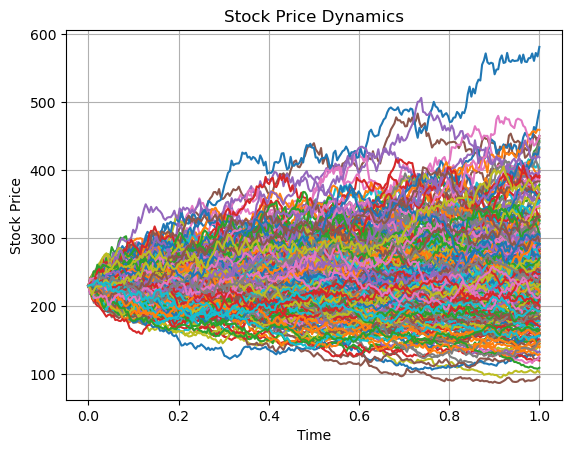

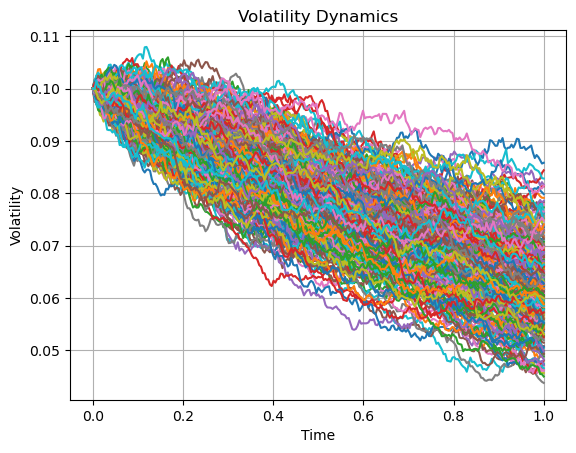

In [168]:
# Parameters of both equations
T = 1.0 # Total time in years
N = 252 # Number of time steps (for 252 trading days)
dt = T / N # Time step size
t = np.linspace(0.0, T, N+1) # Time vector
mu = 0.1 # Expected return
v0 = 0.1 # Initial volatility
kappa = results['parameters']['k'] # Mean reversion rate
theta = results['parameters']['theta'] # Long-term average volatility
sigma = results['parameters']['sigma'] # Volatility of volatility
rho = results['parameters']['rho'] # Correlation coefficient


fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

MC_stock_sim = []

for n in range(300):
    # Generate random shocks - random fluctuations
    #dW1 = np.random.randn(N) * np.sqrt(dt) #For non-correlated Brownian motion
    dW2 = np.random.randn(N) * np.sqrt(dt)
    dW1 = rho*dW2 - np.sqrt(1-rho**2)*np.random.normal(0, np.sqrt(dt), N) #For correlated Brownian motion


    # Initialize arrays for stock price and volatility
    S = np.zeros(N+1)
    v = np.zeros(N+1)
    S[0] = S0 # Initial stock price
    v[0] = v0 # Initial volatility

    # Euler-Maruyama method to solve the stochastic differential equation for stock price dynamics
    for i in range(1, N+1):
        v[i] = v[i-1] + kappa * (theta - v[i-1]) * dt + sigma * np.sqrt(v[i-1]) * dW2[i-1]
        S[i] = S[i-1] * (1 + mu * dt + np.sqrt(v[i-1]) * dW1[i-1])

    MC_stock_sim.append(S)
    # Plot the results
    #plt.figure(figsize=(10, 6))
    #plt.subplot(2, 1, 1)
    ax1.plot(t, S)
    ax2.plot(t,v)
    

ax1.set_title('Stock Price Dynamics')
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock Price')
ax1.grid(True)

ax2.set_title('Volatility Dynamics')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volatility')
ax2.grid(True)


In [169]:
K, r, T, kappa, theta, sigma, rho, v0

(232.97999572753906,
 0.01,
 1.0,
 0.5000000000000651,
 0.005544857989033541,
 0.03809277201518118,
 -7.06642011138357e-15,
 0.1)

# Volatility Smile from Actual Option Data

In [214]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from blackscholes import BlackScholesCall, BlackScholesPut

ticker = yf.Ticker("AAPL")

strike_dates = ticker.options
strike_dates = sorted(strike_dates, key=lambda x: datetime.strptime(x, "%Y-%m-%d")) #Sort strike dates in ascending order

# Get option chain for specific expiration
exp_date = '2025-12-19'
df_calls, df_puts, _ = ticker.option_chain(exp_date)

strikes = np.linspace(20, 350, 50)


In [215]:
# Calculate MC option prices
today_date = datetime.today().strftime('%Y-%m-%d')
trading_days = len(pd.bdate_range(start=today_date, end=exp_date))

def MC_call_pricing(MC_stock_sim, trading_days, strike):
    today_date = datetime.today().strftime('%Y-%m-%d')
    S_T = np.array([x[trading_days-1] for x in MC_stock_sim])
    call_payoffs = np.maximum(S_T - strike, 0)
    call_price = np.mean(call_payoffs)
    return call_price

def MC_put_prices(MC_stock_sim, trading_days, strike):
    today_date = datetime.today().strftime('%Y-%m-%d')
    S_T = np.array([x[trading_days-1] for x in MC_stock_sim])
    put_payoffs = np.maximum(strike - S_T, 0)
    put_price = np.mean(put_payoffs)
    return put_price


MC_call_prices = [MC_call_pricing(MC_stock_sim, trading_days, K) for K in strikes]

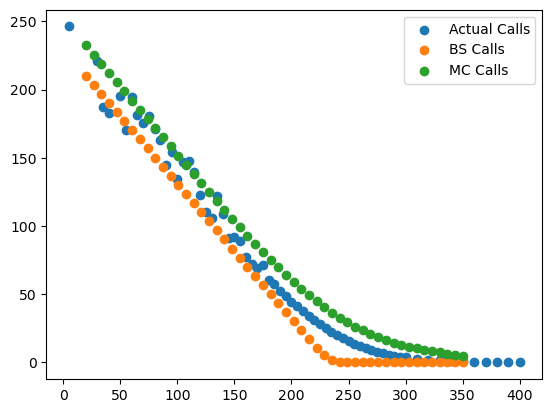

In [216]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

bs_calls = [BS_CALL(S0, K, T, r, sigma) for K in strikes]
calls = [heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0) for K in strikes]
plt.scatter(df_calls['strike'], df_calls['lastPrice'], label='Actual Calls')
#plt.scatter(strikes, calls, label='Heston Calls')
plt.scatter(strikes, bs_calls, label='BS Calls')
plt.scatter(strikes, MC_call_prices, label='MC Calls')
plt.legend()

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Above Maximum Price contracts at index [0]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


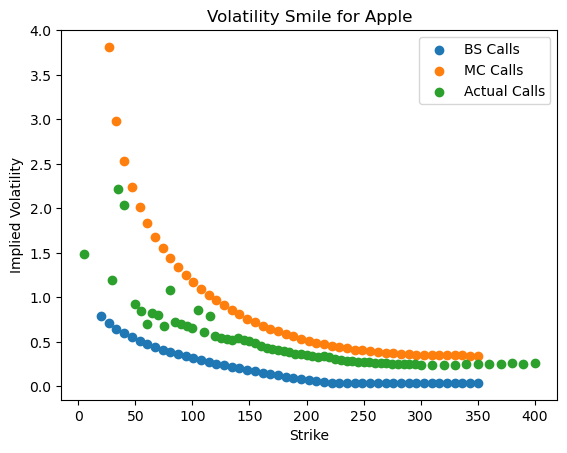

In [217]:
plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.title('Implied Volatility Curve for Apple')


bs_call_ivs = implied_vol(bs_calls,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
mc_call_ivs = implied_vol(MC_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
plt.scatter(strikes, bs_call_ivs, label='BS Calls')
plt.scatter(strikes, mc_call_ivs, label='MC Calls')
plt.scatter(df_calls['strike'], df_calls['impliedVolatility'], label='Actual Calls')
plt.title('Volatility Smile for Apple')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()


c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


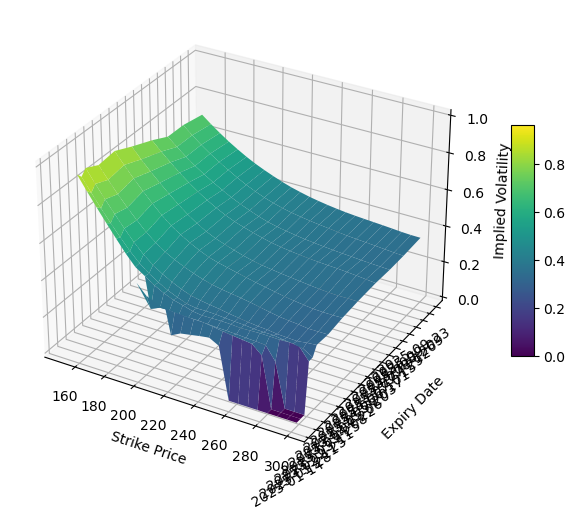

In [228]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.dates import date2num, DateFormatter, DayLocator

strike_dates = strike_dates[:13]

today_date = datetime.today().strftime('%Y-%m-%d')
mc_call_ivs_list = []

for strike in strike_dates:
    df_calls, df_puts, _ = ticker.option_chain(exp_date)
    trading_days = len(pd.bdate_range(start=today_date, end=strike))
    MC_call_prices = [MC_call_pricing(MC_stock_sim, trading_days, K) for K in strikes]
    mc_call_ivs = implied_vol(MC_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
    mc_call_ivs_list.append(mc_call_ivs)

# Convert expiry dates to numerical format
strike_dates_num = date2num(strike_dates)

# Create a meshgrid for the expiry dates (y) and strikes (x)
Y, X = np.meshgrid(strike_dates_num, strikes, indexing='ij')
Z = np.array(mc_call_ivs_list)


# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Format the Y-axis as dates
ax.yaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_locator(DayLocator(interval=14))  # Adjust the interval for dates

# Rotate date labels for readability
plt.setp(ax.get_yticklabels(), rotation=30, ha='right')

# Add labels
ax.set_xlabel('Strike Price')
ax.set_ylabel('Expiry Date')
ax.set_zlabel('Implied Volatility')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()
    

## Volatility Smile

In [219]:
sigma = results['parameters']['sigma']
theta = results['parameters']['theta']
T = 1

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


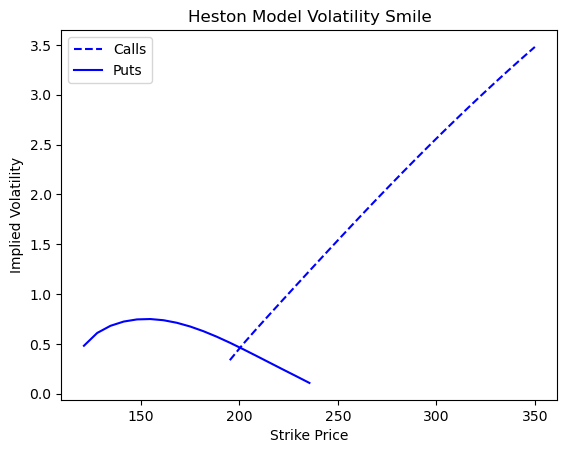

In [220]:
strikes = np.linspace(20, 350, 50)
calls = np.array([heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0) for K in strikes])
puts = np.array([heston_put_price(S0, K, r, T, kappa, theta, sigma, rho, v0) for K in strikes])
call_ivs = implied_vol(calls,S0, strikes, T, r, flag='c',q=0, return_as='numpy')
puts_ivs = implied_vol(puts,S0, strikes, T, r, flag='p',q=0, return_as='numpy')

plt.plot(strikes, call_ivs, 'b--', label='Calls')
plt.plot(strikes, puts_ivs, 'b-', label='Puts')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Heston Model Volatility Smile')
plt.legend()

In [221]:

def black_scholes_price(K, sigma = 0.0179853448252568, r=0.0516):
    """
    Calculate Black-Scholes price for implied vol calculation
    K: Strike price
    sigma: Volatility
    """
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    N_d1 = 0.5 * (1 + special.erf(d1/np.sqrt(2)))
    N_d2 = 0.5 * (1 + special.erf(d2/np.sqrt(2)))
    return S0*N_d1 - K*np.exp(-r*T)*N_d2

def implied_volatility(K):
    """
    Calculate implied volatility using Newton-Raphson method
    K: Strike price
    Returns: Implied volatility
    """
    # Get Heston price
    heston_price_val = heston_call_price(S0, K, r, T, kappa, theta, sigma, rho, v0)
    
    
    # Define objective function for root finding
    def objective(sigma):
        return black_scholes_price(K, sigma) - heston_price_val
    
    # Find implied volatility using Brent's method
    try:
        implied_vol = brentq(objective, 0.0001, 2.0)
        return implied_vol
    except ValueError:
        return np.nan

def calculate_smile(strikes):
    """
    Calculate volatility smile for given strikes
    strikes: Array of strike prices
    Returns: Array of implied volatilities
    """
    return np.array([implied_volatility(K) for K in strikes])

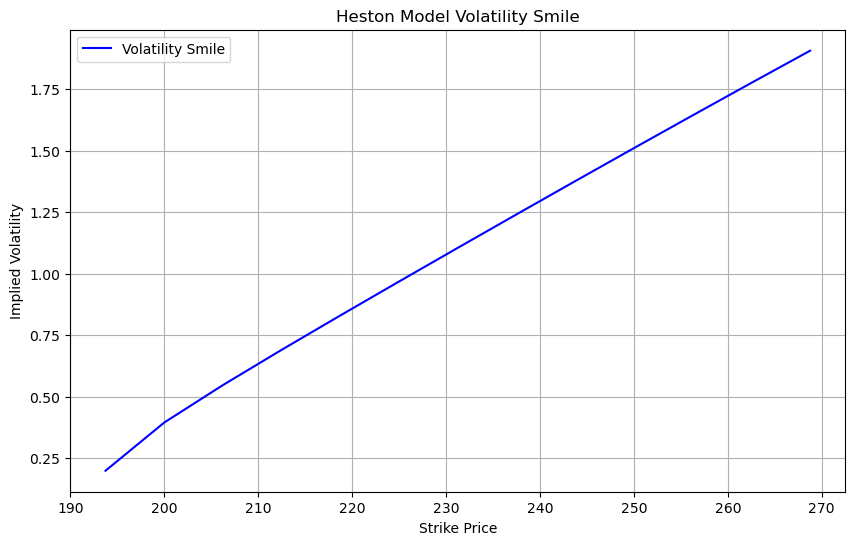

In [222]:
# Generate strikes
strikes = np.linspace(150, 300, 25)
implied_vols = calculate_smile(strikes)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, 'b-', label='Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Heston Model Volatility Smile')
plt.grid(True)
plt.legend()